In [ ]:
# Playgroud Series - Regression of Used Car Prices
    # https://www.kaggle.com/competitions/playground-series-s4e9
    # Your Goal: The goal of this competition is to predict the price of used cars based on various attributes.
    # Metric: Submissions are evaluated using the Root Mean Squared Error (RMSE): how close each prediction is to the actual values, on average.

    # Original Dataset + Notebooks: https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset/code

# General improvements:   
    # Create new notebook for each modification, to make it easier to measure progresses.
    # Just submitt if val results increase: just 5 subs/day.

In [24]:
# Done V2:
    #1 Tune Catboost - ok
    #2 Instead of dropping "clean_title", set 'unknown', to see if it improves the model, even with just 'yes' and 'unknown' options -> slightly worse, so kept removing the feature.
    #3 Feat Engeneering: Features for -150 RMSE [https://www.kaggle.com/competitions/playground-series-s4e9/discussion/531532] -> imporved slightly on val, but not for private data.
    #4 Check duplicates: when removed, got worst train and val result, and on Kaggle as well. Don't remove!

# Done V3:
    # Remove V2 Feature Engeneering, to retake private best score. -> improved, but was not the best!

# Done V4:
    # Included feat eng again, to achieve the best sumbission result. -> did not improve.

# V5:
    # Try new feat eng: https://www.kaggle.com/competitions/playground-series-s4e9/discussion/531616 -> worked, improved public score.

# V6:
    # ON V2, 'expensive_color_ext_encoded' was releavnt on feat importances, try adding it back. Try also 'expensive_color_int_encoded', less important. -> imporved slightly on val, but not for private data. Remove both in V7.

In [25]:
# V1: Public position: 627 of 847   -->  77th of 100 
# V2: Public position: 549 of 1000  -->  55th of 100 
# V3: Public position: 555 of 1009  -->  55th of 100 
# V4: Public position: 557 of 1011  -->  55th of 100
# V5: Public position: 704 of 1505  -->  47th of 100 
# V6: Public position: 708 of 1509  -->  47th of 100 

# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from catboost                        import CatBoostRegressor, Pool
from sklearn.model_selection         import train_test_split, GridSearchCV

pd.set_option('max_colwidth', 200) #cols to be shown
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x) #pandas decimal places

nb_version = '6'

## Load Dataset

In [27]:
train = pd.read_csv('..\\dt\\kaggle\\train.csv', index_col='id')
print(train.shape)
train.reset_index(drop=True, inplace=True)
train[:2]

(188533, 12)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999


# Data Cleaning

## Rename Cols

In [28]:
# Reanme Cols: no need.

## Meanings

In [29]:
# Meanings: all good, but:
    # Clean Title: suggests that the vehicle has never been in an accident severe enough to warrant it being classified as a total loss by an insurance company. 
        # It does not guarantee that the vehicle has never been in any accident at all
        # Also that there are no liens or disputes regarding ownership. 

In [30]:
train[:5]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


## Cat Variations

In [31]:
# Variations of Cat
num_feat = train.select_dtypes(include=['float64', 'int64']).columns
cat_feat = train.select_dtypes(include=['object']).columns
print(f"- Distinct values:\n{train[cat_feat].apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{train[cat_feat].apply( lambda x: x.unique() ) } " )

- Distinct values:
brand             57
model           1897
fuel_type          8
engine          1117
transmission      52
ext_col          319
int_col          156
accident           3
clean_title        2
dtype: int64 

- Variations:
brand           [MINI, Lincoln, Chevrolet, Genesis, Mercedes-Benz, Audi, Ford, BMW, Tesla, Cadillac, Land, GMC, Toyota, Hyundai, Volvo, Volkswagen, Buick, Rivian, RAM, Hummer, Alfa, INFINITI, Jeep, Porsche, McLar...
model           [Cooper S Base, LS V8, Silverado 2500 LT, G90 5.0 Ultimate, Metris Base, A6 2.0T Sport, A8 L 3.0T, Silverado 1500 1LZ, F-150 XLT, M4 Base, Camaro 1LT, Model S P100D, Escalade ESV Platinum, S4 3.0T...
fuel_type                                                                                                                              [Gasoline, E85 Flex Fuel, nan, Hybrid, Diesel, Plug-In Hybrid, –, not supported]
engine          [172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel, 252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel, 320.0H

## Missings

In [32]:
# Missings

In [33]:
# PS: Since I'll start using a Catboost, this is the strategy to handle missings: (gpt)
# - For Numerical features: just keep the missings, it handles them:
        # CatBoost can handle missing values using different strategies. The default mode is to treat missing values as the minimum value (less than all other values) when making splits in decision trees. 
        # This allows the model to consider missing values during the training process without needing to fill them in manuall.
# - For Categorical Features: set 'unknown' or sth like that to missings:
        # While CatBoost can handle missing values in numerical features natively, for categorical features, it is recommended to create a specific category (like "missing" or an empty string) to represent missing values. 
        # This allows the model to treat these entries appropriately during training and ensures that the splits can include this category

In [ ]:
######### try this!

In [ ]:
# def imputer(df):
#     numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
#     categorical_features = df.select_dtypes(include=['object']).columns
#     num_imp = SimpleImputer(strategy='constant', fill_value=int_default_na)
#     obj_imp = SimpleImputer(strategy='constant', fill_value=obj_default_na)
#     df[numeric_features] = num_imp.fit_transform(df[numeric_features])
#     df[categorical_features] = obj_imp.fit_transform(df[categorical_features])
#     return df

In [ ]:
#######

In [34]:
train.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [35]:
train.clean_title.value_counts(dropna=False)

clean_title
Yes    167114
NaN     21419
Name: count, dtype: int64

In [36]:
#Remove clean_title since there is no variation.  -> Instead of dropping "clean_title", set 'unknown', to see if it improves the model, even with just 'yes' and 'unknown' options
# Set 'unknown' on NaN 
#train.loc[train.clean_title.isna(), 'clean_title'] = 'Unknown'
    #-> V2: Set 'Unknown', and did not improve model's performance. Keep removing the feature!

train.drop(columns='clean_title', inplace=True)
#remove also from cat_feat
cat_feat = cat_feat.drop('clean_title')

In [37]:
train.accident.value_counts(dropna=False)

accident
None reported                             144514
At least 1 accident or damage reported     41567
NaN                                         2452
Name: count, dtype: int64

In [38]:
# Set 'unknown' on NaN 
train.loc[train.accident.isna(), 'accident'] = 'unknown'

In [39]:
train.fuel_type.value_counts(dropna=False)

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
NaN                 5083
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [40]:
#Inspect:
#train.loc[train.fuel_type == 'not supported']

#for now:
# Set 'unknown' on NaN 
train.loc[train.fuel_type.isna(), 'fuel_type'] = 'unknown'

In [41]:
train.isna().sum().sort_values()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
price           0
dtype: int64

## Duplicates

In [42]:
#  --->> duplicates: when removed, got worst train and val result, and on Kaggle as well. Don't remove!

In [43]:
# Check Duplication

# Impact of Duplicates
    # Bias in Training: Duplicates can lead to biased training, as the model may give more weight to the duplicated instances. This can skew the model's understanding of the underlying patterns in the data.
    # Overfitting: If duplicates are present, the model might overfit to those repeated instances, leading to poor generalization on unseen data.
    # Evaluation Metrics: Duplicates can affect the evaluation metrics, especially if the duplicates are present in both the training and validation sets.
#train.duplicated().sum()

In [44]:
#inspect duplicates:
#train.loc[train.duplicated(keep=False)].sort_values(by='model')

In [45]:
#train.shape

In [46]:
#drop duplicates and reset index
#train = train.drop_duplicates().reset_index(drop=True)

In [47]:
#train.shape #6 duplicated rows were removed 

## Dtypes

In [48]:
#Dtypes
train.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
price            int64
dtype: object

In [49]:
#convert to int32, lighter:
#train.model_year = train.model_year.astype(int)
train.milage = train.milage.astype(int)
train.price = train.price.astype(int)

In [50]:
#Dtypes
train.dtypes #ok

brand           object
model           object
model_year       int64
milage           int32
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
price            int32
dtype: object

In [51]:
train[:2]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,4999


In [52]:
#Many strings, 3 integers only, ok

In [53]:
#At least 3 features have this, replace:
train = train.replace('–', 'dash') # -> this had no impact on score!

# Checkpoint 1

In [57]:
#train.to_parquet('..\\dt\\v'+nb_version+'\\train_clean.parquet')

In [3]:
#train = pd.read_parquet( '..\\dt\\v'+nb_version+'\\train_clean.parquet')
train = pd.read_parquet( '..\\dt\\v5\\train_clean.parquet') # did not made changes on cheaning
print(train.shape)
train[:2]

(188533, 11)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,4999


# Descriptive Statistical

In [116]:
# num features

In [60]:
num_feat

Index(['model_year', 'milage', 'price'], dtype='object')

In [61]:
#Central tendency metrics: mean and median
ct1 = pd.DataFrame( train[num_feat].apply( np.mean ) ).T
ct2 = pd.DataFrame( train[num_feat].apply( np.median ) ).T

#Dispersion metrics: standard deviation, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( train[num_feat].apply ( np.std ) ).T
d2 = pd.DataFrame ( train[num_feat].apply ( min ) ).T
d3 = pd.DataFrame ( train[num_feat].apply ( max ) ).T
d4 = pd.DataFrame ( train[num_feat].apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( train[num_feat].apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( train[num_feat].apply ( lambda x: x.kurtosis() ) ).T

#Concatenate
nm = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
nm.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [62]:
nm

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,model_year,1974.0,2024.0,50.0,2015.8,2017.0,5.7,-1.0,0.7
1,milage,100.0,405000.0,404900.0,65705.3,57785.0,49798.0,0.9,0.7
2,price,2000.0,2954083.0,2952083.0,43878.0,30825.0,78819.3,20.3,624.0


In [63]:
# Distributions - num features

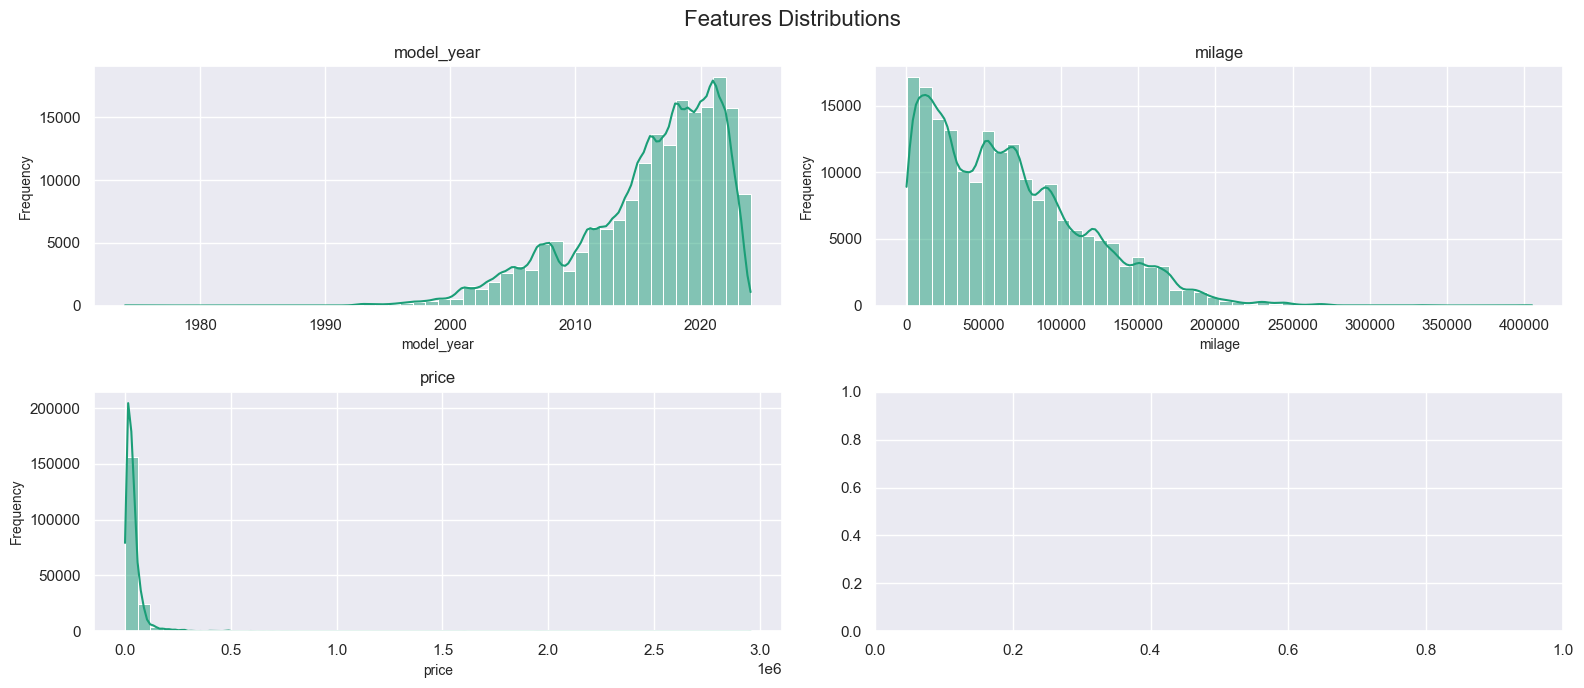

In [64]:
# Histogram
# Set the style for seaborn
sns.set(style="darkgrid")

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 7)) 
fig.suptitle("Features Distributions", fontsize=16)

# Loop through the columns and create histograms
for ax, col in zip(axs.flatten(), train[num_feat]):
    sns.histplot(train[col], ax=ax, bins=50, kde=True, color=sns.color_palette("Dark2")[0])  # Add KDE for smoothness
    ax.set_title(col, fontsize=12)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(True)  # Add grid lines for better readability

# Adjust layout
fig.tight_layout()  
fig.subplots_adjust(top=0.9)

In [65]:
# Distributions - cat features

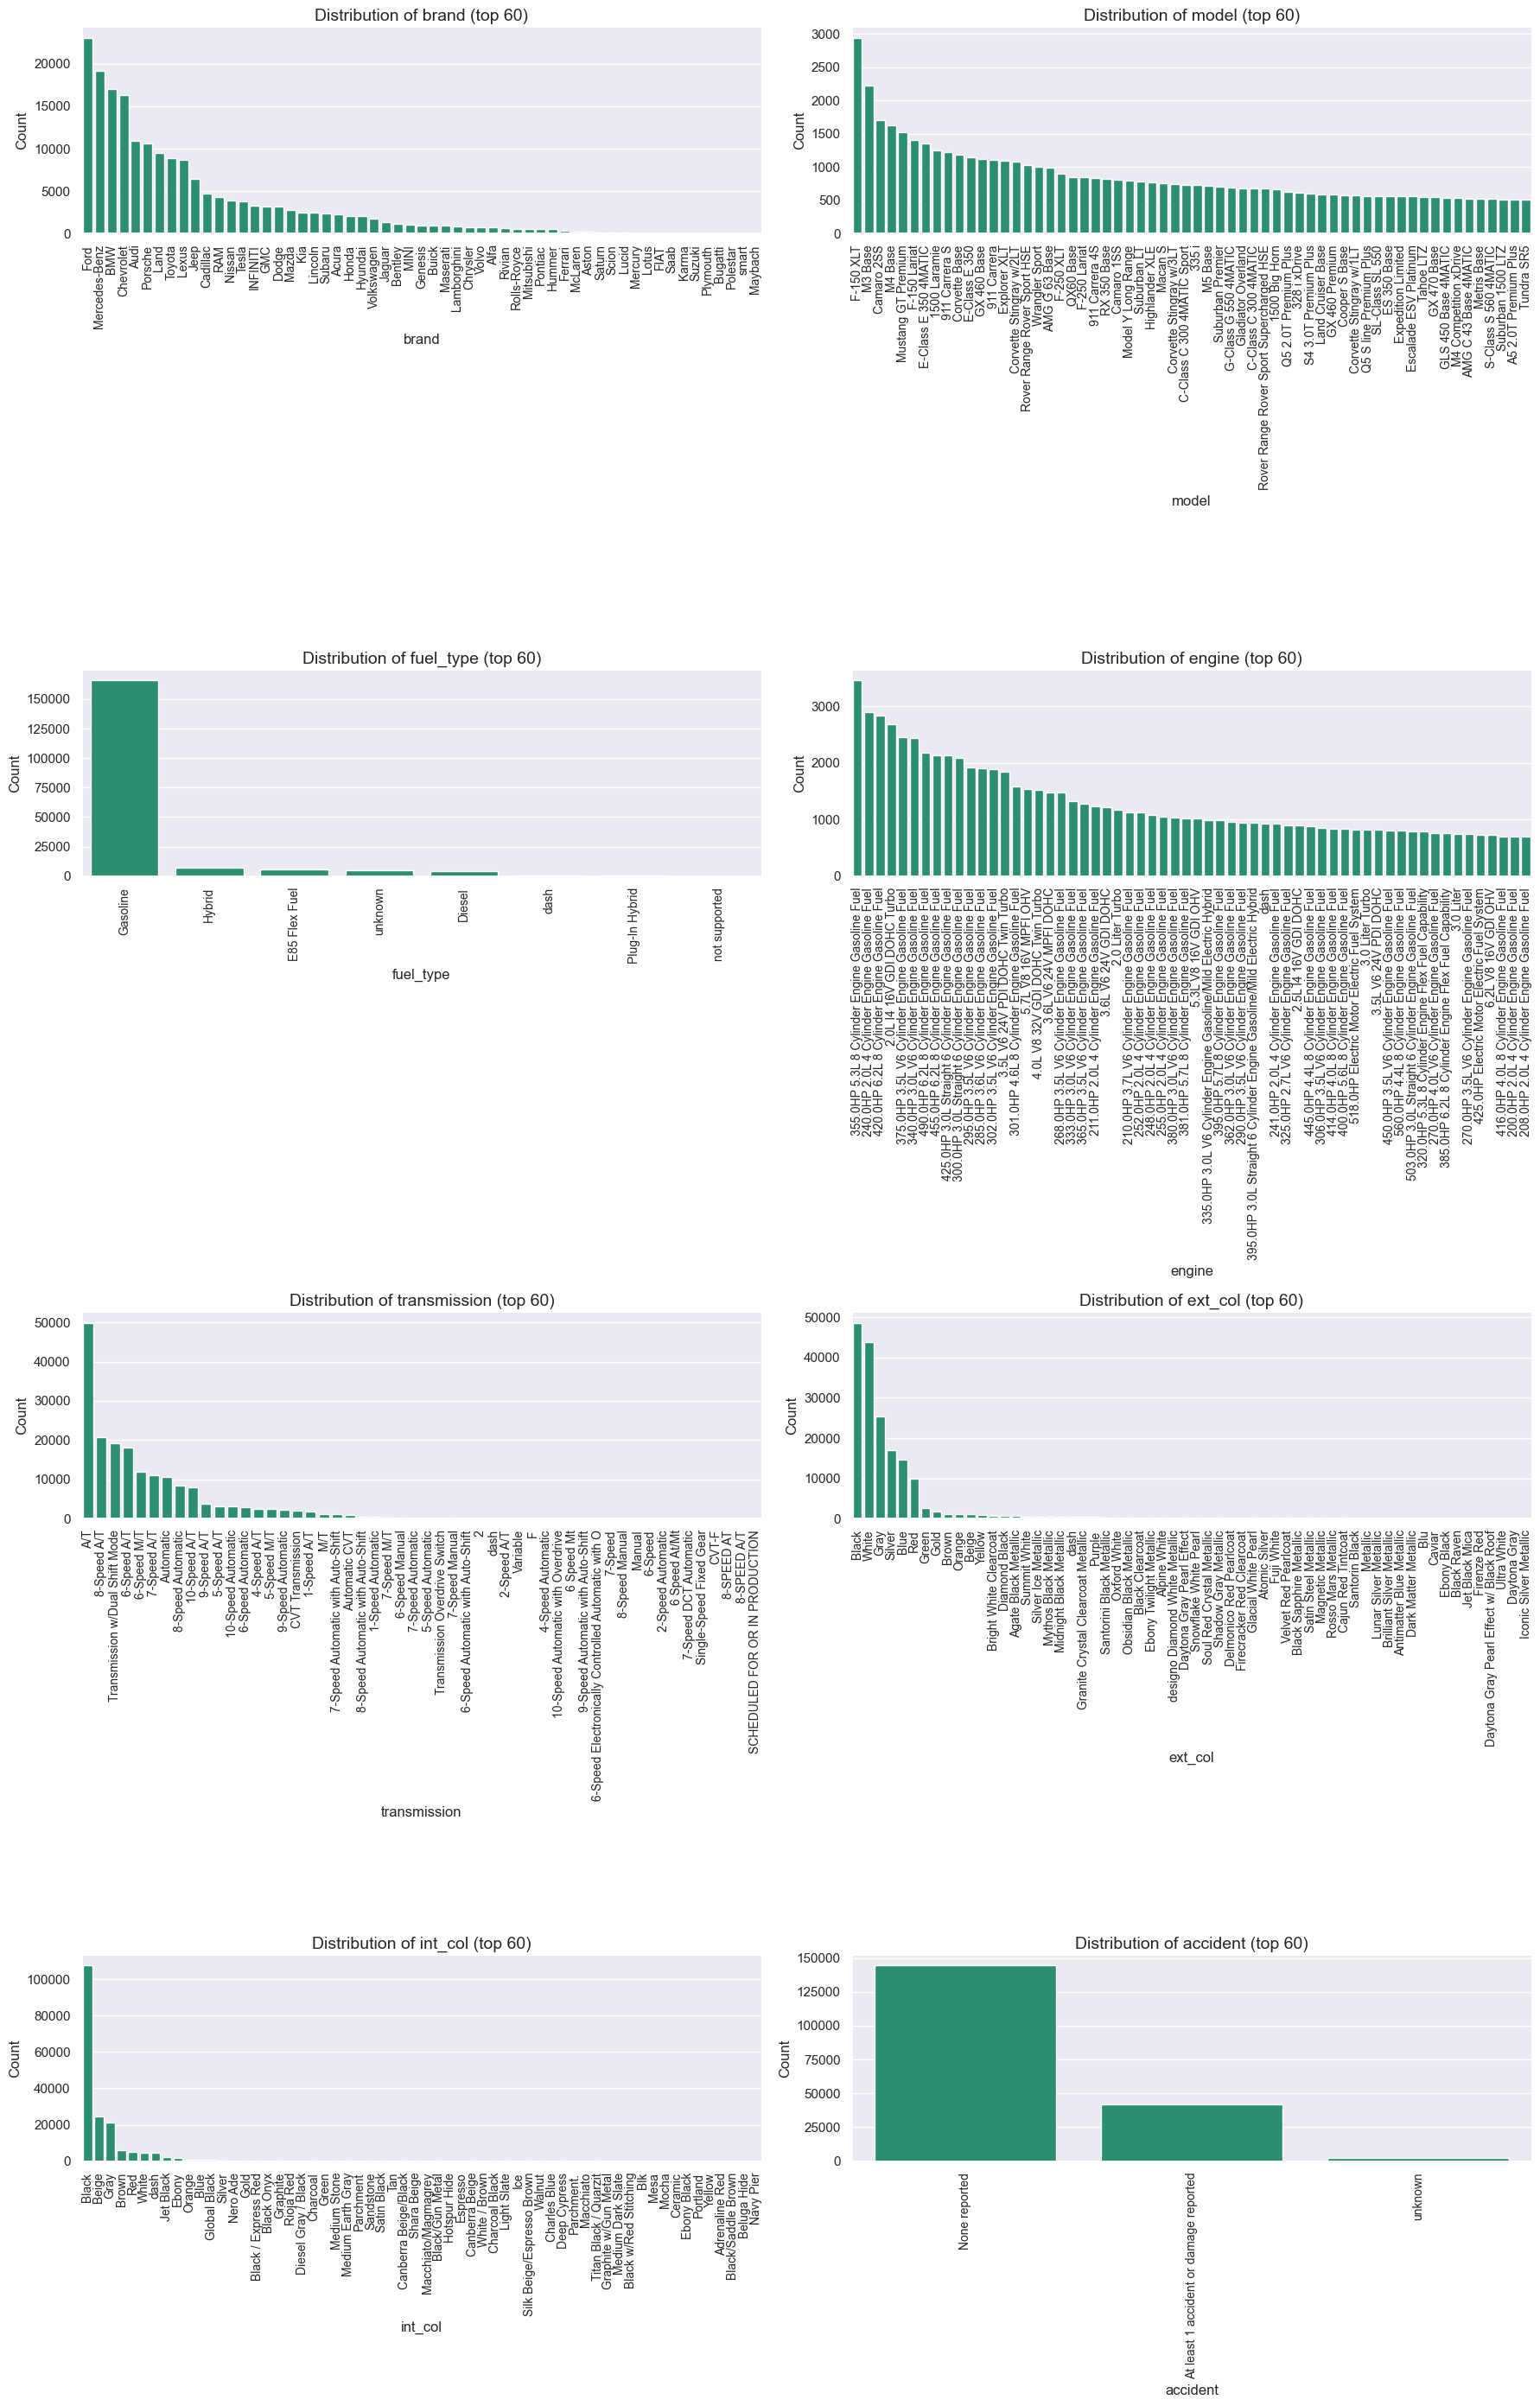

In [66]:
# Histogram
# Set the style for seaborn
sns.set(style="darkgrid")

num_cols = 2
num_rows = (len(cat_feat) + num_cols - 1) // num_cols  # Calculate number of rows needed

plt.figure(figsize=(18, num_rows * 7))  # Adjust height based on number of rows

# Loop through each categorical column and create a bar plot
for i, col in enumerate(cat_feat):
    plt.subplot(num_rows, num_cols, i + 1)  # Create a subplot for each column
    
    # Count occurrences and sort in descending order, limit to 60
    count_data = train[col].value_counts().nlargest(60).reset_index()
    count_data.columns = [col, 'Count']  # Rename columns for clarity

    # Create a count plot with specified color
    sns.barplot(data=count_data, x=col, y='Count', color=sns.color_palette("Dark2")[0], order=count_data[col])
    
    plt.title(f'Distribution of {col} (top 60)', fontsize=14)  # Set the title with larger font size
    plt.xlabel(col, fontsize=12)  # Set x-axis label
    plt.ylabel('Count', fontsize=12)  # Set y-axis label
    plt.xticks(rotation=90, fontsize=10)  # Rotate x labels for better readability
    sns.despine()  # Remove the top and right spines for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots

# Feature Engeneering

In [4]:
train[:2]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,4999


In [5]:
obj_default_na = 'missing'
int_default_na = -1 

SERIES_PATTERN = re.compile(r'^[A-Za-z0-9\-]+')
VERSION_PATTERN = re.compile(r'([0-9]+\.[0-9]+[A-Za-z]*)|([A-Z]+[0-9]*)')
TRIM_PATTERN = re.compile(r'\b(Base|Sport|Premium|Ultimate|XLT|LZ|LT|Plus|Touring|SE|LE|Limited|Platinum|Performance|S|V6|GT|EX|SX|XLE|SR|SL|SV|XSE|TRD|RS|GranSport|Signature|Quad Cab|DRW|Cabriolet|Carbon Edition|Trail Boss|Prestige|Essence|Reserve|xDrive|4MATIC|PreRunner|EcoBoost|Scat Pack|Competition|Adventure Package|Laramie|Grand Touring|Long Range)\b')

def extract_car_features(df):

    if 'model' not in df.columns:
        raise ValueError("Input DataFrame must contain a 'model' column.")
    
    def extract_features(model):
        series = SERIES_PATTERN.search(model)
        version = VERSION_PATTERN.search(model)
        trim = TRIM_PATTERN.search(model)
        
        return {
            'series': series.group(0) if series else obj_default_na,
            'version': version.group(0) if version else obj_default_na,
            'trim': trim.group(0) if trim else obj_default_na
        }
    
    extracted_features = df['model'].apply(extract_features).apply(pd.Series)
    
    df = pd.concat([df, extracted_features], axis=1)
    
    return df


HP_PATTERN = r'(\d+(\.\d+)?)HP'
DISPLACEMENT_PATTERN = r'(\d+\.\d+)L'
CYLINDER_PATTERN = r'(\d+) Cylinder'

ENGINE_CONFIGS = {
    'V6': 'V6', 'V8': 'V8', 'V10': 'V10', 'V12': 'V12',
    'Straight 6': 'Straight 6', 'Flat 6': 'Flat 6', 'I4': 'I4'
}

FORCED_INDUCTION = {'Turbo', 'Twin Turbo'}
VALVE_CONFIGS = {'DOHC', 'SOHC', 'GDI', 'PDI'}
FUEL_SYSTEMS = {'MPFI', 'GDI', 'PDI', 'TFSI'}

def extract_engine_features(df):
    def parse_engine(engine_desc):
        features = {
            'horsepower': int_default_na, 'displacement': int_default_na, 'cylinder_count': int_default_na,
            'engine_configuration':obj_default_na, 'forced_induction': obj_default_na,
            'valve_configuration': obj_default_na, 'fuel_system': obj_default_na, 'mild_hybrid': False,
        }
        
        patterns = {
            'horsepower': (HP_PATTERN, lambda x: float(x)),
            'displacement': (DISPLACEMENT_PATTERN, lambda x: float(x)),
            'cylinder_count': (CYLINDER_PATTERN, lambda x: int(x)),
        }
        
        for feature, (pattern, convert) in patterns.items():
            match = re.search(pattern, engine_desc)
            if match:
                try:
                    features[feature] = convert(match.group(1))
                except ValueError:
                    pass  
        
        features['engine_configuration'] = next((config for config, name in ENGINE_CONFIGS.items() if config in engine_desc), obj_default_na)
        features['forced_induction'] = next((induction for induction in FORCED_INDUCTION if induction in engine_desc),obj_default_na)
        features['valve_configuration'] = next((valve for valve in VALVE_CONFIGS if valve in engine_desc), obj_default_na)
        features['fuel_system'] = next((system for system in FUEL_SYSTEMS if system in engine_desc), obj_default_na)
        features['mild_hybrid'] = 'Mild Electric Hybrid' in engine_desc
        
        return features
    
    unique_engines = df['engine'].unique()
    engine_features = [parse_engine(engine) for engine in unique_engines]
    
    features_df = pd.DataFrame(engine_features, index=unique_engines).reset_index()
    features_df.rename(columns={'index': 'engine'}, inplace=True)
    
    return df.merge(features_df, on='engine', how='left')


def extract_transmission_features(df):
    def get_gear_number(trans):
        match = re.search(r'(\d+)[-\s]?Speed', trans)
        return int(match.group(1)) if match else int_default_na

    def get_transmission_type(trans):
        if 'A/T' in trans or 'Automatic' in trans:
            return 'Automatic'
        elif 'M/T' in trans or 'Manual' in trans:
            return 'Manual'
        elif 'CVT' in trans:
            return 'CVT'
        elif 'DCT' in trans:
            return 'DCT'
        else:
            return 'Other'

    def get_special_features(trans):
        features = []
        if 'Dual Shift Mode' in trans:
            features.append('Dual Shift Mode')
        if 'Auto-Shift' in trans:
            features.append('Auto-Shift')
        if 'Overdrive' in trans:
            features.append('Overdrive')
        if 'Electronically Controlled' in trans:
            features.append('Electronically Controlled')
        if 'Variable' in trans:
            features.append('Variable')
        return ', '.join(features) if features else obj_default_na

    def get_transmission_designation(trans):
        if 'A/T' in trans:
            return 'A/T'
        elif 'M/T' in trans:
            return 'M/T'
        elif 'CVT' in trans:
            return 'CVT'
        elif 'DCT' in trans:
            return 'DCT'
        else:
            return obj_default_na

    df['number_of_gears'] = df['transmission'].apply(get_gear_number)
    df['transmission_mode'] = df['transmission'].apply(get_transmission_type)
    df['special_features'] = df['transmission'].apply(get_special_features)
    df['transmission_designation'] = df['transmission'].apply(get_transmission_designation)

    return df

In [6]:
# apply transformations
train = extract_car_features(train)
train = extract_engine_features(train)
train = extract_transmission_features(train)

In [7]:
print(train.shape) #same, ok

(188533, 26)


In [8]:
train[:1]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,series,version,trim,horsepower,displacement,cylinder_count,engine_configuration,forced_induction,valve_configuration,fuel_system,mild_hybrid,number_of_gears,transmission_mode,special_features,transmission_designation
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200,Cooper,C,S,172.0,1.6,4,missing,missing,missing,missing,False,-1,Automatic,missing,A/T


In [10]:
#V6: adding back 2 features from v2:
expensive_ext_color = ['Blue Caelum', 'Dark Sapphire', 'Bianco Monocerus', 'C / C', 'Ice',
       'Tempest', 'Beluga Black', 'Bianco Icarus Metallic', 
       'BLU ELEOS', 'Shadow Black', 'Nero Noctis', 'Sandstone Metallic',
       'Lizard Green', 'Balloon White', 'Onyx', 'Donington Grey Metallic',
       'China Blue', 'Diamond White', 'Rosso Corsa', 'Granite',
       'Rosso Mars Metallic', 'Carpathian Grey', 'Kemora Gray Metallic',
       'Grigio Nimbus', 'dash', 'Bianco Isis', 'Python Green', 'Fountain Blue',
       'Custom Color', 'Vega Blue', 'Designo Magno Matte',
       'Brands Hatch Gray Metallic', 'Rift Metallic', 'Gentian Blue Metallic',
       'Arancio Borealis', 'BLUE', 'Aventurine Green Metallic', 'Apex Blue',
       'Daytona Gray Pearl Effect', 'Daytona Gray Pearl Effect w/ Black Roof',
       'Matte White', 'Carpathian Grey Premium Metallic', 'Blue Metallic',
       'Santorini Black Metallic', 'Quartzite Grey Metallic',
       'Carrara White Metallic', 'BLACK', 'Kinetic Blue', 'Nero Daytona']

expensive_int_color = ['Dark Auburn', 'Hotspur', 'Cobalt Blue', 'Beluga Hide', 'Linen',
                       'Beluga', 'Black / Brown', 'Nero Ade', 'Sahara Tan', 'Portland']


In [17]:
#1 if it is expensive, selse 0
train['exp_color_ext'] = train.ext_col.isin(expensive_ext_color).astype(int)
train['exp_color_int'] = train.int_col.isin(expensive_int_color).astype(int)

In [19]:
train[:1]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,series,version,trim,horsepower,displacement,cylinder_count,engine_configuration,forced_induction,valve_configuration,fuel_system,mild_hybrid,number_of_gears,transmission_mode,special_features,transmission_designation,exp_color_ext,exp_color_int
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200,Cooper,C,S,172.0,1.6,4,missing,missing,missing,missing,False,-1,Automatic,missing,A/T,0,0


In [20]:
train.isnull().sum()

brand                       0
model                       0
model_year                  0
milage                      0
fuel_type                   0
engine                      0
transmission                0
ext_col                     0
int_col                     0
accident                    0
price                       0
series                      0
version                     0
trim                        0
horsepower                  0
displacement                0
cylinder_count              0
engine_configuration        0
forced_induction            0
valve_configuration         0
fuel_system                 0
mild_hybrid                 0
number_of_gears             0
transmission_mode           0
special_features            0
transmission_designation    0
exp_color_ext               0
exp_color_int               0
dtype: int64

In [21]:
#update cat features with new ones (if applied!)
cat_feat = train.select_dtypes(include=['object']).columns

In [22]:
cat_feat

Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'series', 'version', 'trim',
       'engine_configuration', 'forced_induction', 'valve_configuration',
       'fuel_system', 'transmission_mode', 'special_features',
       'transmission_designation'],
      dtype='object')

# EDA

In [10]:
cat_feat

Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title'],
      dtype='object')

In [44]:
#pass for now

In [ ]:
# plot boxplots of cat features vs price.. problem is there are too many categories! 

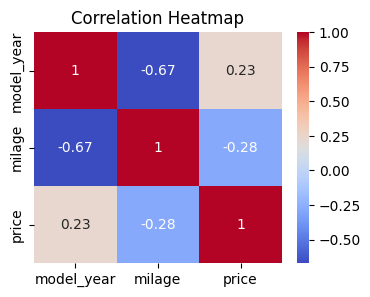

In [23]:
# Correlation Analysis for numerical:
correlation_matrix = train[num_feat].corr()
plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Dataset Split

In [23]:
train[:1]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,series,version,trim,horsepower,displacement,cylinder_count,engine_configuration,forced_induction,valve_configuration,fuel_system,mild_hybrid,number_of_gears,transmission_mode,special_features,transmission_designation,exp_color_ext,exp_color_int
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200,Cooper,C,S,172.0,1.6,4,missing,missing,missing,missing,False,-1,Automatic,missing,A/T,0,0


In [24]:
X = train.drop(columns="price") 
y = train.price

#split between train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 98, test_size = 0.20) #stratify by y

In [25]:
# train data
print('X_train -> ',X_train.shape)
print('y_train -> ',y_train.shape)
# test data
print('X_test -> ',X_test.shape)
print('y_test -> ',y_test.shape)

X_train ->  (150826, 27)
y_train ->  (150826,)
X_test ->  (37707, 27)
y_test ->  (37707,)


# ML

In [26]:
# GridSearch + Cross Validation
#param_grid_cb = {'max_depth': [9 ,15, 17], 'learning_rate': [0.03, 0.05, 0.07]}#  'class_weight': [None, 'balanced', {0: 1, 1: 2.5}  , 'max_leaf_nodes': [10, 40, 100]  , 'min_samples_leaf':[5, 20, 45], }
    #'class_weight': {0: 1, 1: 2.5} balancing manually, to give more importance to the minority class.
# -> max_leaf_nodes and min_samples_leaf did not improve the model's performance

# param_grid_cb = {
#     'max_depth': [7, 9],                # Depth of trees
#     'learning_rate': [0.01, 0.03],         # Learning rate
#     'l2_leaf_reg': [1, 3],                # L2 leaf regularization
#     'n_estimators': [100],            # Number of trees
#     'bagging_temperature': [0]     # Bagging temperature
# }
# print("Parameter grid:{}".format(param_grid_cb))

#Fix the best params so far (V2), to test other improvements on model, using same parameters:
params_best = {'bagging_temperature': [0], 'l2_leaf_reg': [3], 'learning_rate': [0.03], 'max_depth': [9], 'n_estimators': [100]}
print("Parames V2:{}".format(params_best))

Parames V2:{'bagging_temperature': [0], 'l2_leaf_reg': [3], 'learning_rate': [0.03], 'max_depth': [9], 'n_estimators': [100]}


In [27]:
#cat_feat (updated in feat eng)
cat_feat

Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'series', 'version', 'trim',
       'engine_configuration', 'forced_induction', 'valve_configuration',
       'fuel_system', 'transmission_mode', 'special_features',
       'transmission_designation'],
      dtype='object')

In [28]:
#set them:
cat_features = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'series', 'version', 'trim',
       'engine_configuration', 'forced_induction', 'valve_configuration',
       'fuel_system', 'transmission_mode', 'special_features',
       'transmission_designation']

In [29]:
#Catboost Regressor with Grid Search
cb_model = GridSearchCV(CatBoostRegressor(random_state=98, cat_features=cat_features), params_best, cv=2, n_jobs=1, scoring='neg_root_mean_squared_error', return_train_score=True)
cb_model.fit(X_train, y_train)

0:	learn: 75469.0311993	total: 267ms	remaining: 26.4s
1:	learn: 75171.3766905	total: 405ms	remaining: 19.9s
2:	learn: 74859.4755069	total: 533ms	remaining: 17.2s
3:	learn: 74561.1773523	total: 651ms	remaining: 15.6s
4:	learn: 74298.6489307	total: 772ms	remaining: 14.7s
5:	learn: 74045.7504998	total: 880ms	remaining: 13.8s
6:	learn: 73833.2278900	total: 970ms	remaining: 12.9s
7:	learn: 73599.5617466	total: 1.08s	remaining: 12.5s
8:	learn: 73372.8464435	total: 1.2s	remaining: 12.1s
9:	learn: 73155.4408463	total: 1.31s	remaining: 11.8s
10:	learn: 72943.4314343	total: 1.43s	remaining: 11.6s
11:	learn: 72744.5246012	total: 1.54s	remaining: 11.3s
12:	learn: 72560.3290545	total: 1.64s	remaining: 11s
13:	learn: 72381.3740984	total: 1.75s	remaining: 10.8s
14:	learn: 72216.4707811	total: 1.87s	remaining: 10.6s
15:	learn: 72059.5029188	total: 1.98s	remaining: 10.4s
16:	learn: 71904.6111315	total: 2.1s	remaining: 10.3s
17:	learn: 71743.8935162	total: 2.21s	remaining: 10.1s
18:	learn: 71608.6966093

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000012FB56D7080>,
             n_jobs=1,
             param_grid={'bagging_temperature': [0], 'l2_leaf_reg': [3],
                         'learning_rate': [0.03], 'max_depth': [9],
                         'n_estimators': [100]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [30]:
# Get best parameters, and also the best score with cross-validation (VAL DATA):  -> with feature engeneering
print(f"Nb: V{nb_version} ")
print("CatBoost Best parameters (val): {}".format(cb_model.best_params_))
print("CatBoost Best cross-validation score (val): {:.3f}".format(cb_model.best_score_))

Nb: V6 
CatBoost Best parameters (val): {'bagging_temperature': 0, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100}
CatBoost Best cross-validation score (val): -70809.161


In [ ]:
#BEST VAL SO FAR:

# Nb: V6 -> added back 2 feat eng features from V2
# CatBoost Best parameters (val): {'bagging_temperature': 0, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100}
# CatBoost Best cross-validation score (val): -70809.161

In [ ]:
###########

In [31]:
# Nb: V5 - with new feat eng
    # CatBoost Best parameters (val): {'bagging_temperature': 0, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100}
    # CatBoost Best cross-validation score (val): -70837.506

In [32]:
# Access the best estimator
best_model = cb_model.best_estimator_

In [34]:
#Get feature importances:
# Create a Pool object with your training data and specify categorical features
train_pool = Pool(X_train, cat_features=cat_features)

# Get feature importances
feature_importances = best_model.get_feature_importance(data=train_pool)

#Feature importances:
sorted_importances = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)
top_features = [feature for feature, importance in sorted_importances]

In [35]:
#With new feat eng - V5:
print(f"Nb: V{nb_version} ")
print("Top features ordered by importance:", top_features)

Nb: V6 
Top features ordered by importance: ['milage', 'model_year', 'horsepower', 'brand', 'engine_configuration', 'displacement', 'exp_color_ext', 'valve_configuration', 'engine', 'series', 'trim', 'cylinder_count', 'exp_color_int', 'int_col', 'special_features', 'transmission', 'accident', 'transmission_mode', 'ext_col', 'number_of_gears', 'transmission_designation', 'fuel_system', 'fuel_type', 'forced_induction', 'model', 'version', 'mild_hybrid']


In [ ]:
# Nb: V6 
# Top features ordered by importance: ['milage', 'model_year', 'horsepower', 'brand', 'engine_configuration', 'displacement', 'exp_color_ext', 'valve_configuration', 'engine', 'series', 'trim', 
    #'cylinder_count', 'exp_color_int', 'int_col', 'special_features', 'transmission', 'accident', 'transmission_mode', 'ext_col', 'number_of_gears', 'transmission_designation', 'fuel_system', 'fuel_type', 'forced_induction', 'model', 'version', 'mild_hybrid']

# worked: 'exp_color_ext' is important, and improved val score. 

In [36]:
# Nb: V5 
# Top features ordered by importance: ['milage', 'model_year', 'brand', 'engine_configuration', 'displacement', 'horsepower', 'valve_configuration', 'engine', 'series', 'transmission', 'int_col', 'trim', 
# 'special_features', 'cylinder_count', 'accident', 'transmission_mode', 'fuel_system', 'ext_col', 'transmission_designation', 'number_of_gears', 'fuel_type', 'mild_hybrid', 'model', 'version', 'forced_induction']

In [37]:
# Nb: V2 - With feat eng):
# print("Top features ordered by importance:", top_features)
# Top features ordered by importance: ['milage', 'model_year', 'brand', 'engine', 'expensive_color_ext_encoded', 'transmission', 'cylinder', 'expensive_hp', 'int_col', 'fuel_type', 
        #'expensive_color_int_encoded', 'accident', 'ext_col', 'got_v', 'model']

# Kaggle Test Prediction

In [38]:
X_prod = pd.read_csv('..\\dt\\kaggle\\test.csv')
#get id to final df:
X_prod_id = X_prod['id'].copy()
X_prod[:3]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN


In [39]:
#Clean data:

#Remove cols
X_prod.drop(columns='clean_title', inplace=True)
# Missings
X_prod.loc[X_prod.accident.isna(), 'accident'] = 'Unknown'
X_prod.loc[X_prod.fuel_type.isna(), 'fuel_type'] = 'Unknown'
#remove id to predict:
X_prod.drop(columns='id', inplace=True)
#replace the "-"
X_prod = X_prod.replace('–', 'dash')
X_prod[:2]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident
0,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported
1,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,8-Speed A/T,Silver,Black,None reported


In [40]:
#Check duplicates: (can't remove, cause I need to predict prices for all test rows!)
X_prod.duplicated().sum() #duplicates: when removed from train, got worst train and val result, and on Kaggle as well. So, did not remove.

87

In [41]:
#feature engeneering V5: 
X_prod = extract_car_features(X_prod)
X_prod = extract_engine_features(X_prod)
X_prod = extract_transmission_features(X_prod)

In [42]:
#V6: adding back 2 features from v2:
X_prod['exp_color_ext'] = X_prod.ext_col.isin(expensive_ext_color).astype(int)
X_prod['exp_color_int'] = X_prod.int_col.isin(expensive_int_color).astype(int)

In [43]:
X_prod[:2]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,series,version,trim,horsepower,displacement,cylinder_count,engine_configuration,forced_induction,valve_configuration,fuel_system,mild_hybrid,number_of_gears,transmission_mode,special_features,transmission_designation,exp_color_ext,exp_color_int
0,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Rover,R,Base,240.0,2.0,4,missing,missing,missing,missing,False,6,Automatic,missing,A/T,0,0
1,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,8-Speed A/T,Silver,Black,None reported,Rover,R,SE,395.0,3.0,6,Straight 6,missing,missing,missing,True,8,Automatic,missing,A/T,0,0


In [44]:
#predict on prod data:
y_hat_prod = best_model.predict(X_prod)

In [45]:
#Prices predicted
print(y_hat_prod.shape)
y_hat_prod[:5]

(125690,)


array([20769.05560029, 77644.65454071, 54967.73982733, 28344.21384292,
       30338.57840561])

In [46]:
# Prepare for submission: id + predictions:
# Create final dataset
df_sub = pd.concat([ pd.Series(X_prod_id, name='id') , pd.Series(y_hat_prod, name='price') ], axis=1)
df_sub[:3]

,id,price
0,188533,20769.1
1,188534,77644.7
2,188535,54967.7


In [47]:
#Check if sub contains null values -> if there are, solve, cause Kaggle won't accept!
df_sub.isnull().sum()

id       0
price    0
dtype: int64

In [49]:
# Export to submit to Kaggle
df_sub.to_csv('..\\dt\\v'+nb_version+'\\sub_v'+nb_version+'_with_feat_eng.csv', index=False)

In [50]:
#get position and total num of competitors:
pos, comp = 708, 1509
print(f"Public position: {pos} of {comp}  -->  {round(pos/comp*100)}th of 100 ")

Public position: 708 of 1509  -->  47th of 100 
